In [31]:
from spherical_analysis import *
from skimage import io
import blender_tissue_cartography.registration as tcreg
import json
import os

This example notebook will go over ways of validating the rotations that have been detected. Assumes you have a `.json` file with the centers, radii, and rotation matrices. 

Example scenario: Suppose you have a plot of the rotations over time

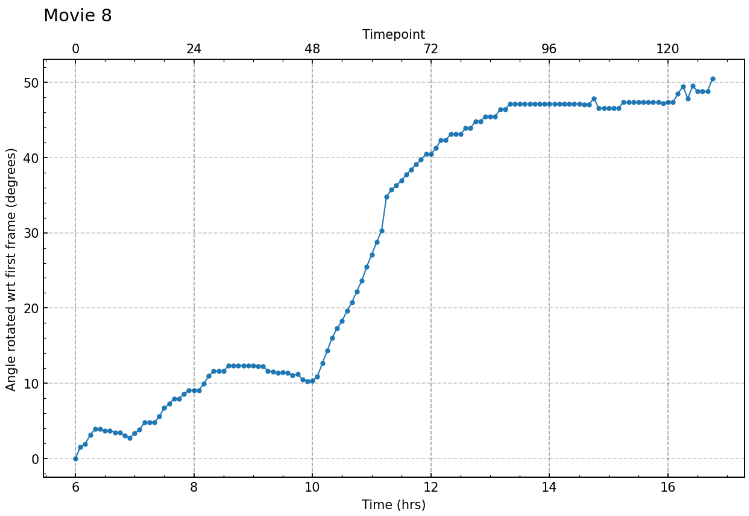

And you see a sudden jump between time 62 and 63. How can you be sure that the rotation detected between those timepoints actually make sense?

First, read in the `.json` of interest

In [5]:
# paremters
json_dir = r"/mnt/data1/Code/GH_local/spherical_harmonic_rotation/dataset_8/"
json_name = r"dataset_8_rotation.json"

# reads in json 
with open(os.path.join(json_dir, json_name), 'r') as f:
    dataset = json.load(f)

# sort by time if not already
dataset = dict(sorted(dataset.items(), key=lambda x: int(x[0][4:])))

# convert back necessary values back to nd_array
for d in dataset.values():
    d['center'] = np.array(d['center'])
    d['rotation_to_next'] = np.array(d['rotation_to_next'])

Load in the relevant times you want to compare

In [ ]:
d1 = dataset['time62']
d2 = dataset['time63']

# note images are read in as ZYX
im1 = clip_pad_image(io.imread(d1['path']), d1['alpha'], d1['padding'])
im2 = clip_pad_image(io.imread(d2['path']), d2['alpha'], d2['padding'])

We can look at the mips

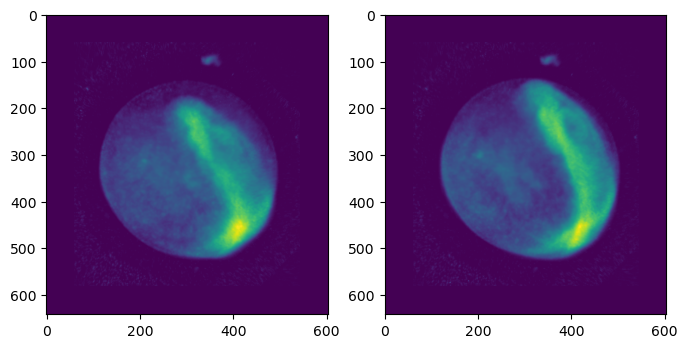

In [ ]:
# plot side by side

# sum over Y 
im1_top = np.sum(im1, axis=1)
im2_top = np.sum(im2, axis=1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 12))
ax1.imshow(im1_top)
ax2.imshow(im2_top)

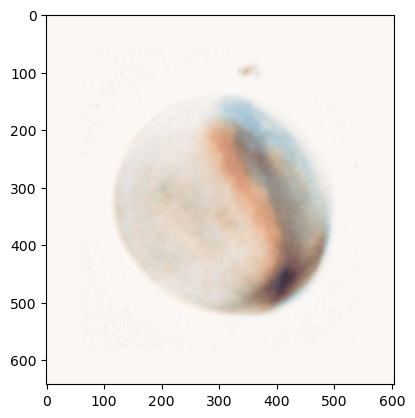

In [ ]:
# plot one on top of another
plt.imshow(im1_top, cmap=plt.cm.Oranges)
plt.imshow(im2_top, alpha=0.5, cmap=plt.cm.Blues)

Indeed, we see a significant difference between these two time points.

Instead of using MIPS, where the rotation might not be obvious from certain angles, we can compare their spherical pullbacks

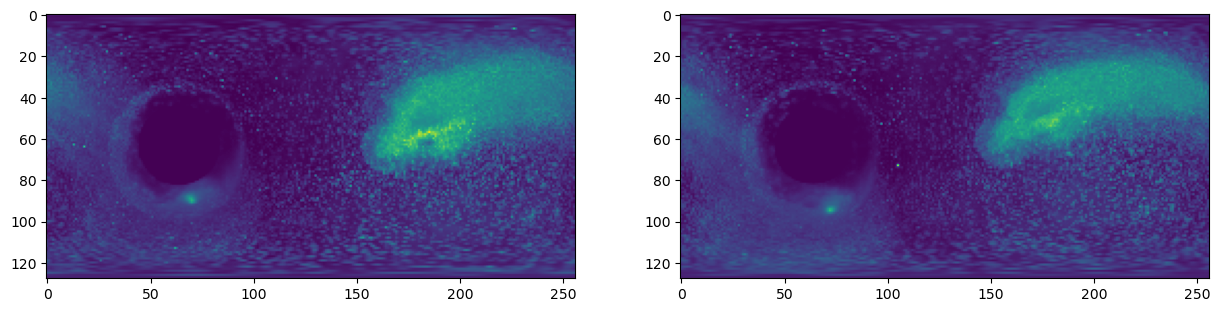

In [25]:
# create interpolated volumes for both images
im1_vol = create_interpolated_volume(im1)
im2_vol = create_interpolated_volume(im2)

# get their pullbacks
f = np.max(spherical_pullback(im1_vol, d1['center'], d1['radius'], thickness=64, theta_res=128, phi_res=256), axis=0)
g = np.max(spherical_pullback(im2_vol, d2['center'], d2['radius'], thickness=64, theta_res=128, phi_res=256), axis=0)

# plot side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 12))
ax1.imshow(f)
ax2.imshow(g)

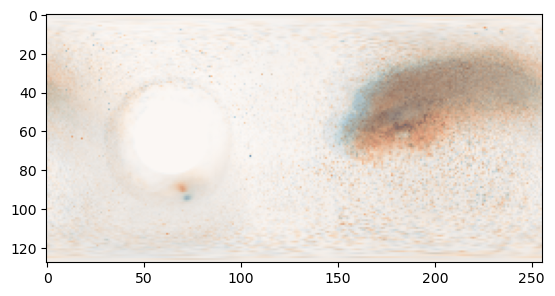

In [16]:
# plot one on top of another
plt.imshow(f, cmap=plt.cm.Oranges)
plt.imshow(g, alpha=0.5, cmap=plt.cm.Blues)

We also see a significance difference in their overlaps. 

Okay, now that we have made sure that there is a difference between the two times, lets check if the rotation we detected will successfully "register" one to the other.

In [17]:
print(d1['rotation_to_next']) # print rotation matrix between the two adjacent times

[[ 0.98533158  0.15034036  0.08074309]
 [-0.15870399  0.98120842  0.10974101]
 [-0.0627273  -0.12094553  0.99067526]]


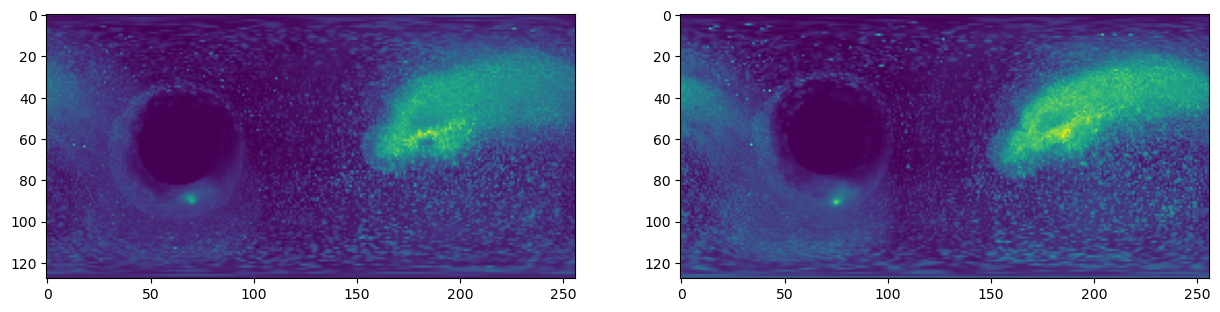

In [28]:
# create a rotated volume for the second time point 
# (this is equivalent to rotating the ROI or embeddings) 
# We do not use the inverse since the function does backwards resampling, similar to 
# scipy's affine_transform. 
im2_vol_rotated = create_rotated_volume(im2_vol, d1['rotation_to_next'], d2['center']) 


# get the pullback
g_rot = np.max(spherical_pullback(im2_vol_rotated, d2['center'], d2['radius'], thickness=64, theta_res=128, phi_res=256), axis=0)

# plot side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 12))
ax1.imshow(f)
ax2.imshow(g_rot)

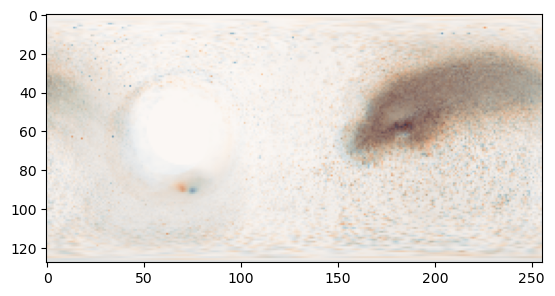

In [29]:
# plot one on top of another
plt.imshow(f, cmap=plt.cm.Oranges)
plt.imshow(g_rot, alpha=0.5, cmap=plt.cm.Blues)

We see a good amount of overlap, after applying the correct rotation. Suggests that the rotation detected between these two times actually make sense.

We can also rotate the images themselves and compare their MIPs

In [32]:
# construct affine transform
affine_matrix = (tcreg.package_affine_transformation(np.eye(3), d2['center']) @
                    tcreg.package_affine_transformation(d1['rotation_to_next'], np.zeros(3)) @
                    tcreg.package_affine_transformation(np.eye(3), -d2['center']))   
# rotate
im2_rotated = ndimage.affine_transform(im2, affine_matrix, output_shape=None, order=1,
                                        mode='constant', cval=0.0, prefilter=False) # bilinear interpolation

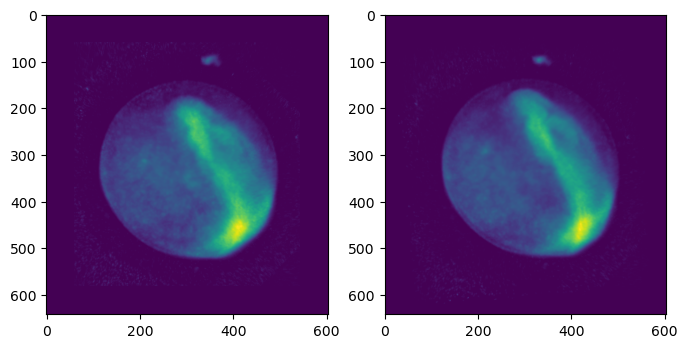

In [33]:
# plot side by side
# sum over Y 
im1_top = np.sum(im1, axis=1)
im2_top_rotated = np.sum(im2_rotated, axis=1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 12))
ax1.imshow(im1_top)
ax2.imshow(im2_top_rotated)

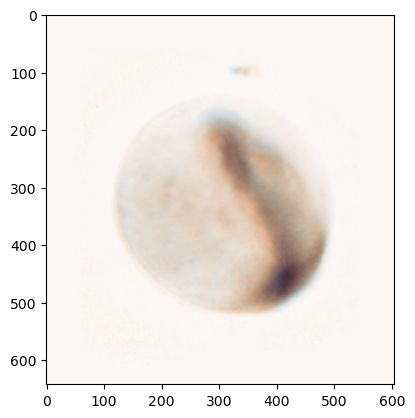

In [35]:
# plot one on top of another
plt.imshow(im1_top, cmap=plt.cm.Oranges)
plt.imshow(im2_top_rotated, alpha=0.5, cmap=plt.cm.Blues)